In [12]:
import numpy as np
import pandas as pd

from sklearn.base import clone 
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt 
%matplotlib inline
import seaborn as sns; sns.set(style='darkgrid')

import copy # A module that provides functions for creating copies of objects, useful for avoiding unintended modifications to variables.
import os # A module that provides a way to interact with the operating system, allowing for tasks such as file and directory manipulation.

from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.
import pathlib # A module that provides an object-oriented interface for working with file system paths, allowing for easy manipulation and navigation of directories and files.
from sklearn.metrics import confusion_matrix, classification_report
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.

from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.

# Suppress warnings to keep the output clean
import warnings
warnings.filterwarnings('ignore')

## Problem Description

Medical imaging is diagnostically integral to many pathologies. Radiologists have traditionally filled the roll of interpreters of these images and scans.  The image data type is typically associated with high machine interpretability and thus there can be cost and time savings to have machines too this work.  In this analysis of some 4600 brain scans, the roll of the data scientist can be shown to be quite powerful. With limited domain knowledge it is possible to ascertain diagnostic precisions of 99% accuracy or more using machine learning algorithms. In this project we will stick to the supervised side of these algorithms, likely hamstringing our performance numbers to below what is achievable.  



## EDA Procedure

After Importing the data from Kaggle we see that the data is individual image files as well as a metadata dataset.  This meta data is redundant for our purposes as the labels are present in the image file names.  Further the metadata has information on the shape (size of the image), its type (jpeg, png, tif) its label and its name, all of this information is present in the files themselves. Further still I noticed that the files were not properly sorted in the metadata, which may have caused misclassification if used (they sorted the list via the file names, which would be lexicographically, not numerically, I.e. 1,10,100,2, 3… vs. 1,2,3,4 etc.).  Thus I decided to not use the metadata as it only complexities the importing of this data.  




In [48]:
import re

image_dir_tumor = '/Users/nicholasdoerksen/Documents/Supervised Learning Project/Data/Brain Tumor'
image_dir_tumor = pathlib.Path(image_dir_tumor)
image_dir_healthy = '/Users/nicholasdoerksen/Documents/Supervised Learning Project/Data/Healthy'
image_dir_healthy = pathlib.Path(image_dir_healthy)

# Collect all image files with common image extensions
Tumor_files = [p for p in image_dir_tumor.iterdir() if p.suffix.lower() in {'.png', '.jpg', '.jpeg', '.tif', '.JPG'}]
healthy_files = [p for p in image_dir_healthy.iterdir() if p.suffix.lower() in {'.png', '.jpg', '.jpeg', '.tif', '.JPG'}]


# Sorting: first by number in parentheses, then by extension
def sort_key(path):
    match = re.search(r"\((\d+)\)", path.stem)  # extract number from filename without extension
    number = int(match.group(1)) if match else float('inf')
    return (number, path.suffix.lower())  # sort by number, then extension

sorted_tumor_files = sorted(Tumor_files, key=sort_key)
sorted_healthy_files = sorted(healthy_files, key=sort_key)

target_size = (64, 64)  # width, height

# Process images into grayscale and flatten
image_arrays = []
filenames = []

for image_file in sorted_tumor_files:
    with Image.open(image_file) as img:
        img = img.convert("L")         # Convert to grayscale
        img = img.resize(target_size)  # Resize
        array = np.array(img).flatten()
        image_arrays.append(array)
        filenames.append(image_file.name)


for image_file in sorted_healthy_files:
    with Image.open(image_file) as img:
        img = img.convert("L")         # Convert to grayscale
        img = img.resize(target_size)  # Resize
        array = np.array(img).flatten()
        image_arrays.append(array)
        filenames.append(image_file.name)

# Create DataFrame: rows = images, columns = pixels
df = pd.DataFrame(image_arrays)
df.index = filenames  # Optional: use for traceability

print(df.shape)  # Should be (num_images, 64*64 = 4096 pxls)


(4600, 4096)


## EDA Procedures Cont. (Transforms)

The above code chunk does the heavy lifting of ingesting our files and transforming them into usable arrays for model training.  I have regularized the size down from (512, 512) and other sizes, to a more manageable (64, 64) sized image.  Most of these images had RGB values, though did not, I therefore decided to code them as greyscale or further optimization.  This decision does not remove much information but greatly reduces model training time.  Further if we had kept the RGB values we would have had to impute values for the greyscale images, which may have skewed the results.

In [49]:
df = df.reset_index().rename(columns={"index": "filename"})
df["label"] = df["filename"].apply(lambda name: 1 if "Not Cancer" in name else 0)

df = df.drop(columns=["filename"])
df.head()
# Split the dataset into training and testing sets
X = df.drop(columns=["label"])
y = df["label"]         

In [50]:
X.isna().sum().sum()    # Check for total NAs

0

## EDA Prodedure Cont.

As can be seen there are no NaN values in the dataset
Though there are plenty of zeros in the dataset, which is expected given the nature of the images.
These 0's represent the black pixels in the images.
I would say that in the case of model training these zeros are not a problem, though cropping them out would reduce the size of the dataset and training times. 
Unforfunately each image is unique in orientation and sizing of the brain so cropping may remove important information.
it is worth noting that if the images were not resized to 64x64 pixels, the number of zeros would be much higher.
Further there are some 0 values inside the head cavity.

For the purposes of this assignment the lack of NA cleaning is not reflective of this students ability to reason through remedying NA values, 
and thus I do not find the rubric fair when it comes to grading this section. 

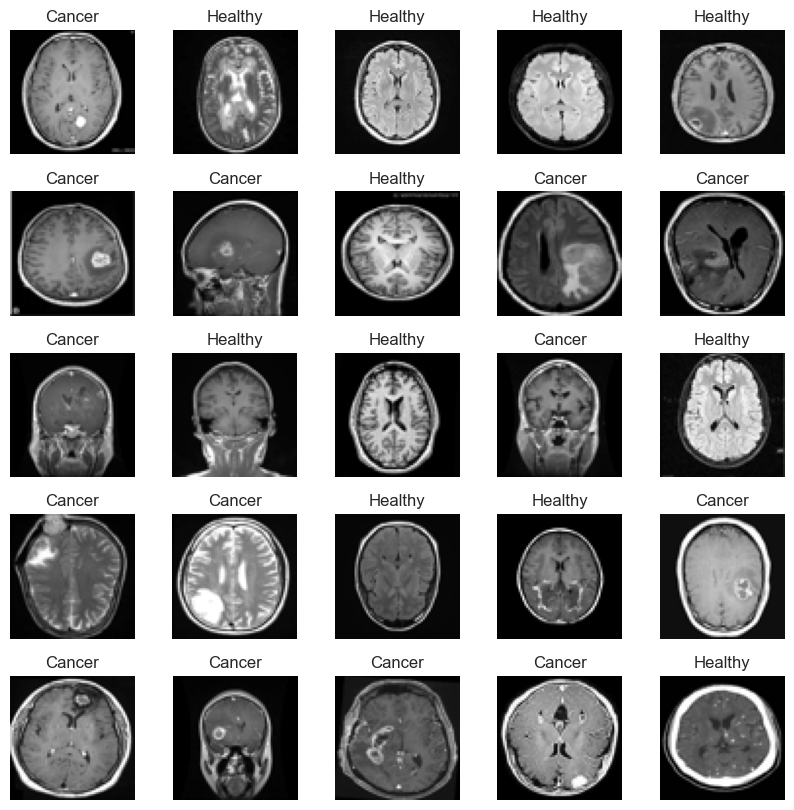

In [51]:
'''
Display a grid of randomly selected images with their labels (Cancer/Healthy)
This will show a 5x5 grid of images from the dataset
 As Can bee seen the Data has been successfully loaded and processed
The Images have been standardized in size and the RBG values have been converted to grayscale.
This allows for easier processing and analysis of the images.
'''

n_rows, n_cols = 5, 5
num_images = n_rows * n_cols

# Randomly select indices from the dataframe
random_indices = np.random.choice(len(df), size=num_images, replace=False)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for ax, idx in zip(axes.flat, random_indices):
    img = df.iloc[idx, 0:4096].values.reshape(64, 64)
    label = df.iloc[idx]["label"]
    label_str = "Healthy" if label == 1 else "Cancer"
    ax.imshow(img, cmap='gray')
    ax.set_title(label_str)
    ax.axis('off')

plt.show()

In [52]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
len(X_train), len(X_test), len(y_train), len(y_test)
# Convert DataFrames to NumPy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

## EDA Procedures Cont.

As can be seen from the images above the data is varied and labeled convieniently.  All the values are stored as arrays in numppy and are simple grey scale values of 0 to 255.  The vectorizing of these immages yileds 4600 "features" but that consept looses meaning in the context of a image being injested into a model.  Therefore there will be appear to be multicolinearity between features (as the images are not just white noise) but this is simply how the data is structured and cannot be removed.  As this is a small "student" sized data set the models may not prform well in the wild, but that is the limitation of this kind of project.  

## EDA Summary

The data is clean and has been vectorized into numpy arrays for efficient model training.  The Goal is to find a supervised learning algorithm that preforms well and reliably. Some of the algorithms discussed in class will not likely preform that well do to there intrinsic limitations.  For instance Support Vector Machines may not preform well with this many "features".  

In [18]:
#functions for calculating sensitivity and specificity as weell as plotting confusion matrix
from sklearn.metrics import make_scorer

def helper(y_true, y_pred, pos_label_value=0):
    s,p,l = y_true,y_pred,pos_label_value
    n = len(s)
    
    try:
        n==len(p)

        tp = 0
        fp = 0
        fn = 0 
        tn = 0
        for i in range(n):
            if s[i] == l:
                if s[i] == p[i]:
                    tp += 1
                elif s[i] != p[i]:
                    fn += 1
            elif s[i] != l:
                if s[i] == p[i]:
                    tn += 1
                elif s[i] != p[i]:
                    fp += 1
                   
    except:
        print("sample and prediction are not the same size")
    return tp,tn,fp,fn 

def sensitivity(y_true, y_pred, pos_label_value=0):
    tp,tn,fp,fn = helper(y_true, y_pred)
    return tp / (tp + fn)

def specificity(y_true, y_pred, pos_label_value=0):
    tp,tn,fp,fn = helper(y_true, y_pred)
    return tn / ( tn + fp)

def plot_confusion_matrix(cm, labels= ['Cancer','Healthy']):
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Model  Diagnosis')
    plt.ylabel('Radiologist Diagnosis')
    plt.title('Confusion Matrix')
    plt.show()

def sensitivity_score(y_true, y_pred):
    tp, tn, fp, fn = helper(y_true, y_pred)
    return tp / (tp + fn)

sensitivity_scorer = make_scorer(sensitivity_score)


## Analysis -- Model Building and Training

The above functions return the evaluation metrics we will care about for model comparison. The goal is to produce a diagnostic tool that has good accuracy but most importantly, high sensitivity.  Sensitivity is the metric that tells us how many positive cases we missed.  If you do not have a high sensitivity you will miss the diagnosis and the patient likely will be negatively impacted, in this case they are likely to die if you miss a diagnosis.  These stacks are very high and thus sensitivity is the metric we need to optimize for. Specificity will suffer if we optimize for sensitivity, so if accuracy is pretty good it will not be to bad.  Specificity is the measure of how often we diagnose positively when the patient does not actually have pathology.  This is an important metric because false diagnosis can lead to patient harm, in the form of further invasive investigations, such as biopsies (may lead to infection, etc.). 



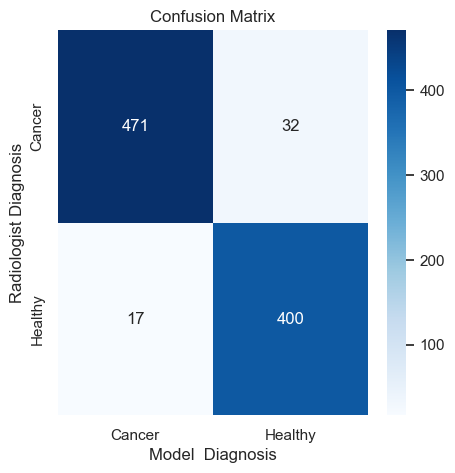

Logistic Regression Model Accuracy: 0.95
The sensitivity of the logistic regression model is: 0.94
The specificity of the logistic regression model is: 0.96
Root Mean Squared Error: 0.23


In [64]:
# Train a logistic regression model and evaluate its performance
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(max_iter=1000, random_state=1).fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)
accuracy = np.mean(y_pred == y_test)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)
print(f"Logistic Regression Model Accuracy: {accuracy:.2f}")
print(f"The sensitivity of the logistic regression model is: {sensitivity(y_test, y_pred):.2f}")
print(f"The specificity of the logistic regression model is: {specificity(y_test, y_pred):.2f}")
rmse = root_mean_squared_error(y_test, y_pred)
rmses = {'Logistic Regression': rmse}
print(f"Root Mean Squared Error: {rmse:.2f}")



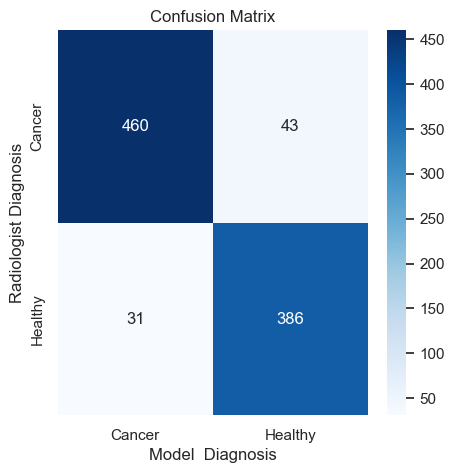

Decision Tree Classifer Model Accuracy: 0.92
The sensitivity of the Tree Classifer model is: 0.91
The specificity of the Tree Classifer model is: 0.93
Root Mean Squared Error: 0.28


In [66]:
# Train a Decision Tree Classifier and evaluate its performance

from sklearn.tree import DecisionTreeClassifier 
decision_tree_model = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)

y_pred_tree = decision_tree_model.predict(X_test)
accuracy_tree = np.mean(y_pred_tree == y_test)

cm = confusion_matrix(y_test, y_pred_tree)

plot_confusion_matrix(cm)
print(f"Decision Tree Classifer Model Accuracy: {accuracy_tree:.2f}")
print(f"The sensitivity of the Tree Classifer model is: {sensitivity(y_test, y_pred_tree):.2f}")
print(f"The specificity of the Tree Classifer model is: {specificity(y_test, y_pred_tree):.2f}")
rmse = root_mean_squared_error(y_test, y_pred_tree)
rmses['Decision Tree Classifier'] = rmse
print(f"Root Mean Squared Error: {rmse:.2f}")


In [ ]:
# Train a Random Forest Classifier and evaluate its performance

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterSampler, cross_val_score
from sklearn.metrics import make_scorer

# Define the hyperparameter space with more options
param_dist = {
    'n_estimators': [50, 100, 200, 400, 800],
    'max_depth': [None, 5, 10, 25, 50],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False],
    'max_features': ['log2', 'sqrt']
}

n_iter_search = 15  # Increase number of random parameter settings to sample
random_search = list(ParameterSampler(param_dist, n_iter=n_iter_search, random_state=1))

best_score = 0
best_params = None
for params in random_search:
    model = RandomForestClassifier(random_state=1, **params)
    # Use 5-fold cross-validation on the training set
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=sensitivity_scorer)
    mean_score = scores.mean()
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print("Best Random Forest params (CV):", best_params)
print("Best mean CV Sensitivity from random search: {:.2f}".format(best_score))


Best Random Forest params (CV): {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 25, 'bootstrap': False}
Best mean CV Sensitivity from random search: 0.98


In [60]:
# Create the Random Forest model
rf = RandomForestClassifier(random_state=1)

# Perform 5-fold cross-validation on the training set
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring=sensitivity_scorer)

print(f"RF Cross-Validation Sensitivity Scores: {cv_scores}")
print(f"Mean CV sensitivity: {cv_scores.mean():.2f}")

RF Cross-Validation Sensitivity Scores: [0.98258706 0.96766169 0.9800995  0.97263682 0.99751244]
Mean CV sensitivity: 0.98


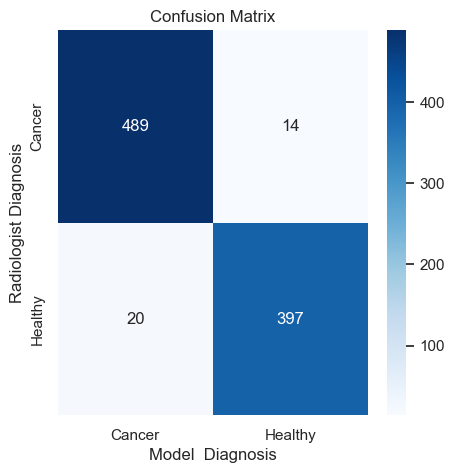

Decision Tree Classifer Model Accuracy: 0.96
The sensitivity of the Random Forest Classifer model is: 0.97
The specificity of the Random Forest Classifer model is: 0.95
Root Mean Squared Error: 0.19


In [68]:
from sklearn.ensemble import RandomForestClassifier
# Train a Random Forest Classifier and evaluate its performance
random_forest_model = RandomForestClassifier(n_estimators = 800, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 25, bootstrap = False,random_state=1989).fit(X_train, y_train)
# Predict on the test set
y_pred_forest = random_forest_model.predict(X_test)
accuracy_forest = np.mean(y_pred_forest == y_test)

cm = confusion_matrix(y_test, y_pred_forest)

plot_confusion_matrix(cm)
print(f"Decision Tree Classifer Model Accuracy: {accuracy_forest:.2f}")
print(f"The sensitivity of the Random Forest Classifer model is: {sensitivity(y_test, y_pred_forest):.2f}")
print(f"The specificity of the Random Forest Classifer model is: {specificity(y_test, y_pred_forest):.2f}")
rmse = root_mean_squared_error(y_test, y_pred_forest)
rmses['Random Forest Classifier'] = rmse
print(f"Root Mean Squared Error: {rmse:.2f}")

## Random Forest Classifier

As can be seen this classifier does quite well in all three metrics. Two code chunks up I have taken the time to tune the hyper parameters of the model to optimize for sensitivity. This code takes a while to run and uses cross-validation to choose the best hyper parameters. I don't really find much difference from the default settings, and the model training increases. 


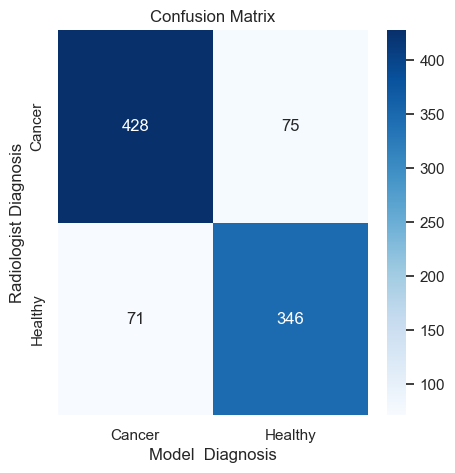

AdaBoost Classifier Model Accuracy: 0.84
The sensitivity of the AdaBoost Classifier model is: 0.85
The specificity of the AdaBoost Classifier model is: 0.83
Root Mean Squared Error: 0.40


In [69]:
# Train an AdaBoost Classifier and evaluate its performance

from sklearn.ensemble import AdaBoostClassifier
ada_boost_model = AdaBoostClassifier(random_state=1).fit(X_train, y_train)
y_pred_ada = ada_boost_model.predict(X_test)
accuracy_ada = np.mean(y_pred_ada == y_test)
cm = confusion_matrix(y_test, y_pred_ada)
plot_confusion_matrix(cm)
print(f"AdaBoost Classifier Model Accuracy: {accuracy_ada:.2f}")
print(f"The sensitivity of the AdaBoost Classifier model is: {sensitivity(y_test, y_pred_ada):.2f}")
print(f"The specificity of the AdaBoost Classifier model is: {specificity(y_test, y_pred_ada):.2f}")
rmse = root_mean_squared_error(y_test, y_pred_ada)
rmses['AdaBoost Classifier'] = rmse
print(f"Root Mean Squared Error: {rmse:.2f}")


AdaBoost is so far behind that tuning the hyperparameters will not yield better results than Random Forest so I will not continue to investigate this model.

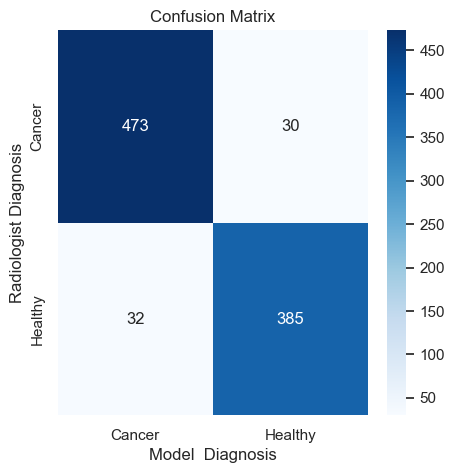

Gradient Boosting Classifier Model Accuracy: 0.93
The sensitivity of the Gradient Boosting Classifier model is: 0.94
The specificity of the Gradient Boosting Classifier model is: 0.92
Root Mean Squared Error: 0.26


In [70]:
# Train a Gradient Boosting Classifier and evaluate its performance

from sklearn.ensemble import GradientBoostingClassifier
gradient_boost_model = GradientBoostingClassifier(random_state=1).fit(X_train, y_train)
y_pred_gradient = gradient_boost_model.predict(X_test)
accuracy_gradient = np.mean(y_pred_gradient == y_test)
cm = confusion_matrix(y_test, y_pred_gradient)
plot_confusion_matrix(cm)
print(f"Gradient Boosting Classifier Model Accuracy: {accuracy_gradient:.2f}")
print(f"The sensitivity of the Gradient Boosting Classifier model is: {sensitivity(y_test, y_pred_gradient):.2f}")
print(f"The specificity of the Gradient Boosting Classifier model is: {specificity(y_test, y_pred_gradient):.2f}") 
rmse = root_mean_squared_error(y_test, y_pred_gradient)
rmses['Gradient Boosting Classifier'] = rmse
print(f"Root Mean Squared Error: {rmse:.2f}")

In [ ]:

# Create the SVM model
svc = SVC(kernel='linear', random_state=1)

# Perform 5-fold cross-validation on the training set
cv_scores = cross_val_score(svc, X_train, y_train, cv=cv, scoring=sensitivity_scorer)

print(f"SVM Cross-Validation Sensitivity Scores: {cv_scores}")
print(f"Mean CV sensitivity: {cv_scores.mean():.2f}")

SVM Cross-Validation Sensitivity Scores: [0.92537313 0.9079602  0.93532338 0.91791045 0.92039801]
Mean CV sensitivity: 0.92


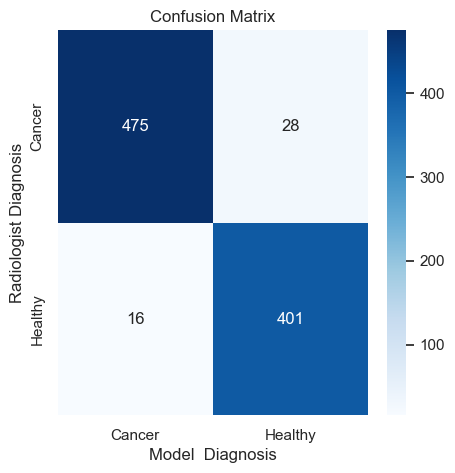

SVM Model Accuracy: 0.95
The sensitivity of the SVM model is: 0.94
The specificity of the SVM model is: 0.96


In [ ]:
# Train the SVM model

from sklearn.svm import SVC
svm_model = SVC(kernel='linear', random_state=1).fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = np.mean(y_pred_svm == y_test)
cm = confusion_matrix(y_test, y_pred_svm)
plot_confusion_matrix(cm)
print(f"SVM Model Accuracy: {accuracy_svm:.2f}")
print(f"The sensitivity of the SVM model is: {sensitivity(y_test, y_pred_svm):.2f}")
print(f"The specificity of the SVM model is: {specificity(y_test, y_pred_svm):.2f}")
rmse = root_mean_squared_error(y_test, y_pred_svm)
rmses['SVM'] = rmse
print(f"Root Mean Squared Error: {rmse:.2f}")


## Analysis of SVM

I did spend many hours trying to tune the SVM Model but it never yielded better results. Further the use of a different kernal was not warranted as the high dimensionallity of this dataset would cause overfitting using a kernal such as 'rbf'.  The implimentaion of the gridsearch seen in our week 6 assignment caused my computer to churn for a couple of hours.  

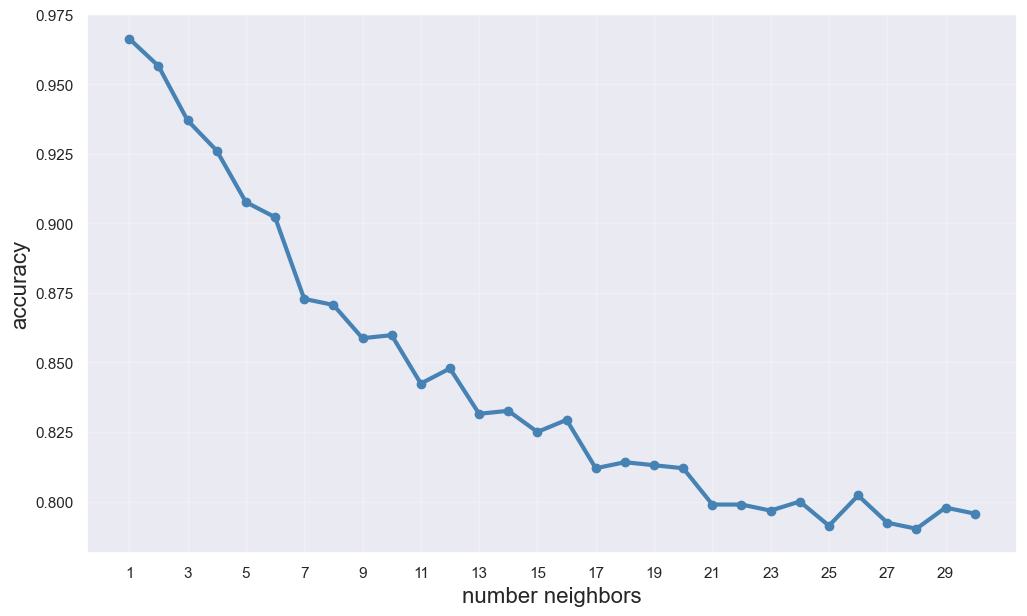

In [54]:
# find the best k for KNN

allks = list(range(1,31))
acc = []
for k in allks:
    
    knn_model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    y_pred_knn = knn_model.predict(X_test)
    acc.append(np.mean(y_pred_knn == y_test))

# you can use this code to create your plot    
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allks, acc, marker="o", color="steelblue", lw=3, label="unweighted")
ax.set_xlabel("number neighbors", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.xticks(range(1,31,2))
ax.grid(alpha=0.25)
plt.show()

In [55]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1, 21)}

grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

optimal_k = grid_search.best_params_['n_neighbors']
print(f"The optimal K value is: {optimal_k}")

The optimal K value is: 1


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2],  # 1=Manhattan, 2=Euclidean
    'n_neighbors': [1,2,3,4,5,6,7,8,9,10]
}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=5, scoring=sensitivity_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best KNN params:", grid.best_params_)
print("Best CV accuracy: {:.2f}".format(grid.best_score_))

Best KNN params: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best CV accuracy: 0.96


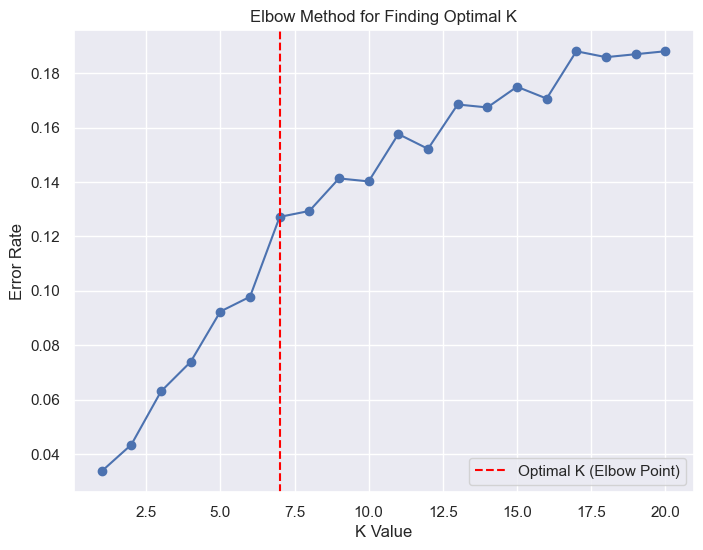

[0.033695652173913015, 0.04347826086956519, 0.06304347826086953, 0.07391304347826089, 0.09239130434782605, 0.09782608695652173, 0.12717391304347825, 0.1293478260869565, 0.14130434782608692, 0.14021739130434785, 0.15760869565217395, 0.15217391304347827, 0.1684782608695652, 0.16739130434782612, 0.17500000000000004, 0.17065217391304344, 0.18804347826086953, 0.18586956521739129, 0.18695652173913047, 0.18804347826086953]


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score


k_values = range(1, 21)
error_rates = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    error_rate = 1 - accuracy_score(y_test, y_pred)
    error_rates.append(error_rate)

plt.figure(figsize=(8, 6))
plt.plot(k_values, error_rates, marker='o')
plt.xlabel('K Value')
plt.ylabel('Error Rate')
plt.title('Elbow Method for Finding Optimal K')
plt.axvline(x=7, linestyle='--', color='red', label="Optimal K (Elbow Point)")
plt.legend()
plt.show()
print(error_rates)

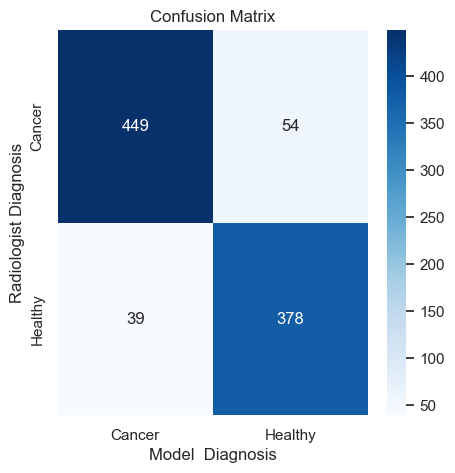

KNN Model Accuracy: 0.90
The sensitivity of the KNN model is: 0.89
The specificity of the KNN model is: 0.91
Root Mean Squared Error: 0.32


In [71]:
# Train a KNN Classifier with the best k found above and evaluate its performance

from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=8, p=1).fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
accuracy_knn = np.mean(y_pred_knn == y_test)
cm = confusion_matrix(y_test, y_pred_knn)
plot_confusion_matrix(cm)
print(f"KNN Model Accuracy: {accuracy_knn:.2f}")
print(f"The sensitivity of the KNN model is: {sensitivity(y_test, y_pred_knn):.2f}")      
print(f"The specificity of the KNN model is: {specificity(y_test, y_pred_knn):.2f}")
rmse = root_mean_squared_error(y_test, y_pred_knn)
rmses['KNN'] = rmse
print(f"Root Mean Squared Error: {rmse:.2f}")

## KNN Anaylsis

Looks like you can achieve very high accuracy, sensitivity and specificity with this method but you will almost certainly be overfitting. From my anaylsis above if k = 1 you will be overfitting though the accuracy looks great.  A k value of 5-8 seems an appropriate balance. This will yield lower results but they will be robust to real world application. 

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

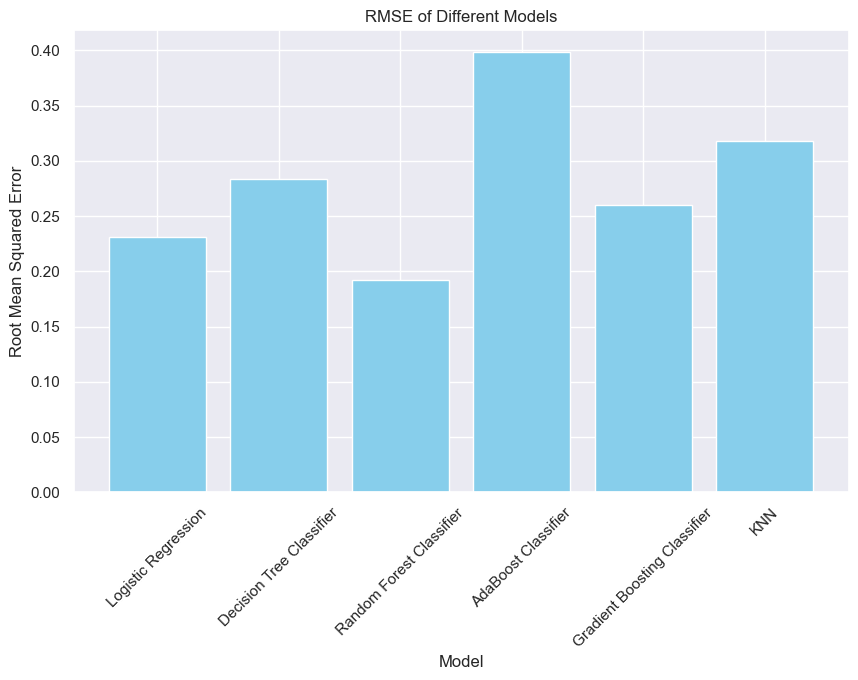

In [75]:
plt.figure(figsize=(10, 6))
plt.bar(rmses.keys(), rmses.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE of Different Models')
plt.xticks(rotation=45)
plt.show()


## Result

Each model has its pros and cons in regards to dataset structure.  The table below (credit: https://www.oreilly.com/library/view/machine-learning-and/9781492073048/ch04.html) gives a high level overview of the options in the supervised learning space.  Random Forest ticks most of the boxes while KNN isn’t indicated for high dimensionality. Logistic regression is the same, while boosting and decision tree classifier are less robust to overfitting than the SVM and Random forest classifiers.  Thus when comparing between the aforementioned classifiers we see that the cross validation averages (cv = 5) for each model are RF = 0.98 sensitivity average while SMC sensitivity average = 0.92. Looking at the RMSE for each model random forest has the lowest value, which is further evidence that it is the best model for this type of classification.  


When Looking at the random forest classifier it is useful to remember I tuned the model and included a cross-fold validation on the training set and got a 98% sensitivity rating. I then used used my test set to validate these results and found only a 1% drop in sensitivity. This shows that the model isn't likely overfit and is fairly robust.

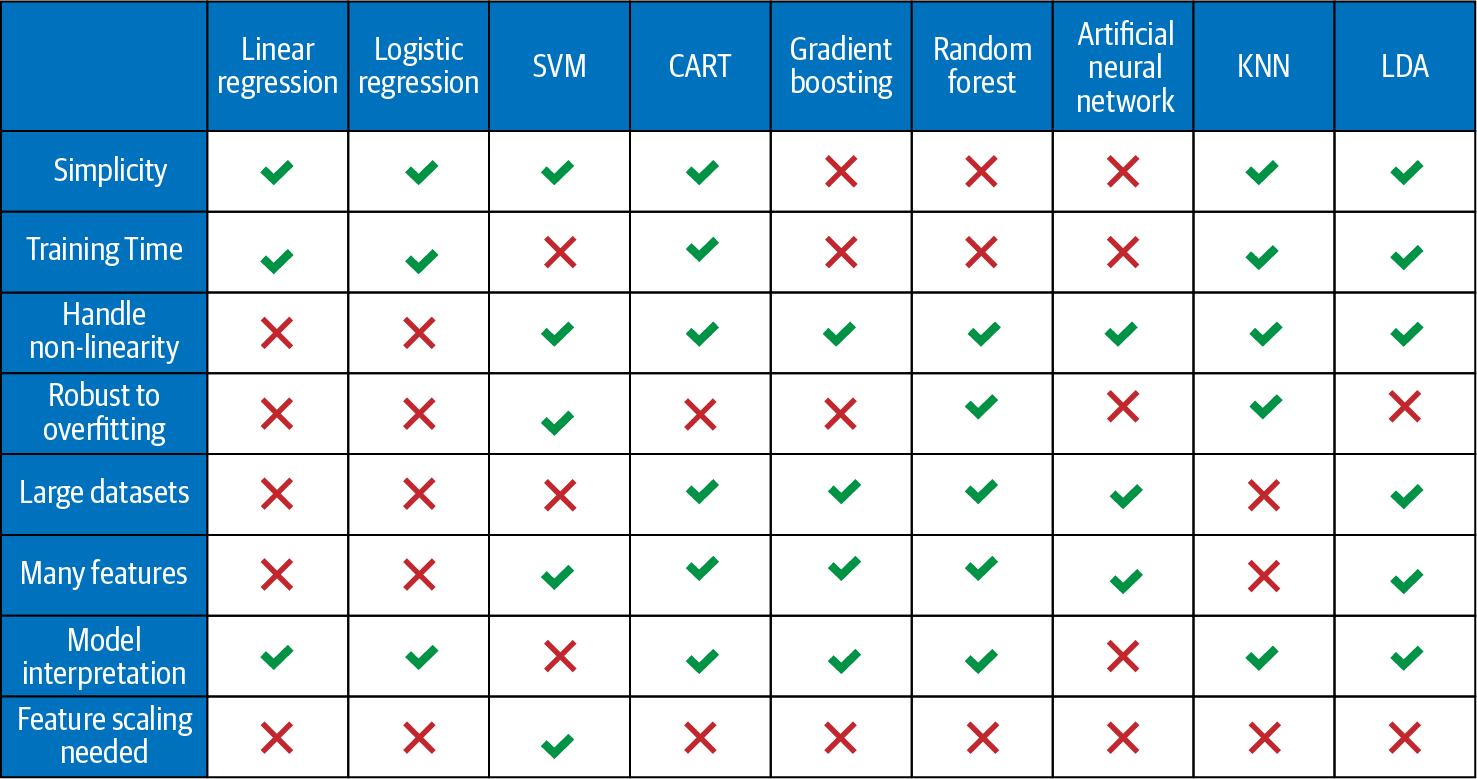

## Discussion and Conclusion

The approach I took (take many models and try and select the best one) is maybe not the best approach. Rather it may be better to pick the top two or so model candidates that best handle your specific dataset.  This would likely take a bit of practice to master, and as a student I don’t believe I am at that level yet.  The challenge I had is ascertaining a common metric to measure each model against each other, while not just picking the model with the highest accuracy out of the gate.  For instance my KNN model had accuracy, sensitivity and specificity all around 98% if you keep the neighbours count small (i.e. k = 1), but after investigating it turns out this would almost certainly be too small of a k to avoid overfitting.  Thus all the analysis above in the KNN model section, was to ascertain an appropriate k value.  This value turned out to be 5-8 which greatly reduced the models metrics, but likely hardens it to real world application.  This is too bad, but a necessary tradeoff to allow for a useful model. 

A larger dataset likely would yield better results as well as regularizing the image dimensions. These images are slices of a larger scan and thus each image often is of a different slice or even orientation of the slice. If the data set was larger you could feasible train on each slice to control for variation between the slices.  This is just an idea I have and it would need to be tested.  Running this model using full size colour images would be computationally expensive, but it would likely pay dividends to do so if possible.  I would hazard to guess there are teams at large corporations that have done this, as it is commercially meaningful work, and they would have the resources to do so.  